In [148]:
cd ..

D:\투빅스\audio_to_mel


In [3]:
!git clone https://github.com/tuanad121/Python-WORLD.git

Cloning into 'Python-WORLD'...


# Audio to Mel

In [4]:
%matplotlib inline  
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import time
import os

In [ ]:

# make paths and flags of src
dirpaths = ['English/EmoV-DB_sorted',
            'English/AudioWAV',
            'English/SAVEE']

flags = ['.wav','.wav','.wav']
"""srcpaths = []
srcflags = []
vi_index = []
"""
cnt = 0
for idx, (dirpath, flag) in enumerate(zip(dirpaths, flags)):
    speakerlist = os.listdir(dirpath)#화자
    speakerlist.sort()
    #print(speakerlist)
    for speaker in speakerlist :
        if os.path.isdir(os.path.join(dirpath, speaker)):
            tmp = os.path.join(dirpath, speaker)
            emotionlist = os.listdir(tmp)#감정
            emotionlist.sort()
            #print(emotionlist)
            for emotion in emotionlist :
                #wav file
                tmp_em = os.path.join(tmp, emotion)
                audiolist = os.listdir(tmp_em)#audio
                audiolist.sort()
                #print(tmp_em, len(audiolist))
                
                for audio in audiolist :
                    filename, extension = os.path.splitext(audio)
                    if extension == '.wav':
                        cnt += 1

In [6]:
print("우리 eng data 몇개~?? : ",cnt)

우리 eng data 몇개~?? :  14814


Data 예시~

In [149]:
y, sr = librosa.load("English/EmoV-DB_sorted/bea/Disgusted/disgust_113-140_0126.wav", sr=22050)
print('Audio Sampling Rate: '+str(sr)+' samples/sec')
print('Total Samples: '+str(np.size(y)))
secs=np.size(y)/sr
print('Audio Length: '+str(secs)+' s')
ipd.Audio(y, rate=sr)

Audio Sampling Rate: 22050 samples/sec
Total Samples: 144552
Audio Length: 6.555646258503401 s


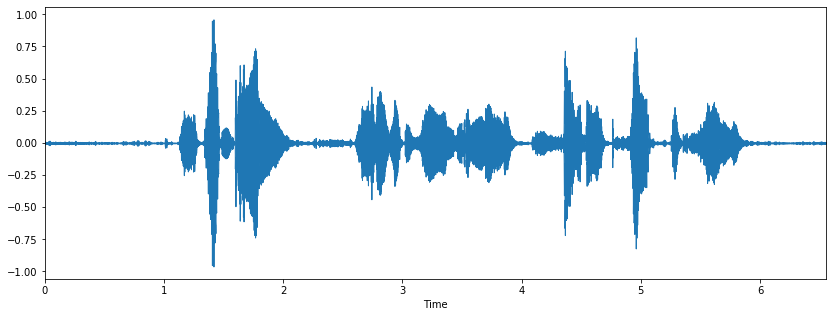

In [150]:
fig = plt.figure(figsize = (14,5))
librosa.display.waveplot(y, sr=sr)

### audio to mel (.wav -> .npy)

librosa로 한번에 해보장~

In [151]:
def Mel_lib(y, sr = 22050, n_fft=1024, hop_length=256, win_length=1024, n_mels=40 ):
    # mel-spectrogram
    #y, sr = librosa.load(wav_file, sr=22050)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, win_length=win_length,)
    
    
    print("Wav length: {}, Mel_S shape:{}".format(len(y)/sr,np.shape(S)))
    
    return S
mel_lib = Mel_lib(y)

Wav length: 6.555646258503401, Mel_S shape:(40, 565)


STFT->Mel Filter나눠서 해보장~

In [152]:
def Mel_S(y, sr = 22050, n_fft=1024, hop_length=256, win_length=1024, n_mels=40):
    # mel-spectrogram
    S = librosa.core.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    # phase 에 대한 정보를 날린다.
    D = np.abs(S)**2
    # mel spectrogram (512 --> 40)
    mel_basis = librosa.filters.mel(sr, 1024, n_mels=n_mels)
    mel_S = np.dot(mel_basis, D)
    
    print("Wav length: {}, Mel_S shape:{}".format(len(y)/sr,np.shape(mel_S)))
    # STFT

    return mel_S
mel_S = Mel_S(y)


Wav length: 6.555646258503401, Mel_S shape:(40, 565)


In [153]:
np.array_equal(mel_lib,mel_S)
#이렇게 하나 저렇게하나 똑같음~

True

time of audio_to_mel

In [154]:
start = time.time()
mel_lib = Mel_lib(y)
print(time.time()-start)

Wav length: 6.555646258503401, Mel_S shape:(40, 565)
0.022938013076782227


In [155]:
start = time.time()
mel_S = Mel_S(y)
print(time.time()-start)

Wav length: 6.555646258503401, Mel_S shape:(40, 565)
0.025440216064453125


Mel_S써서 하지 뭐

# Feature Extraction (from Mel)

### MFCC
음색,톤의 특징이 담겨있다. (감정인식에서 사용가능)
##### Mel -> log -> DCT -> MFCC

In [156]:
#log compression
log_mel_S = librosa.power_to_db(mel_S)
log_mel_S.shape

(40, 565)

In [157]:
# mfcc (DCT)
mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=13)
mfcc = mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
mfcc.shape

(13, 565)

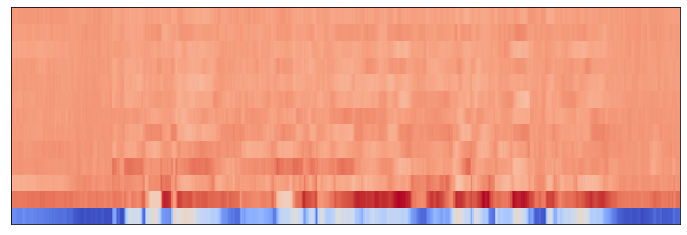

In [158]:
plt.figure(figsize=(12,4))
librosa.display.specshow(mfcc)

In [159]:
def MFCC(mel,n_mfcc = 13):
    #log compression
    log_mel_S = librosa.power_to_db(mel_S)

    mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=n_mfcc)
    mfcc = mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
    
    return mfcc

### MCEPs
MFCC와 비슷하지만, Filter Bank가 적용되지 않았다.
#### 세가지 방법 01,02 -> 실패!      03 -> 좀 많이 어렵.... 
#### MCEPs 01 

Mel -> Mel Filter제거 ->(Linear Spectogram) -> Spectral Envelop(MCEPS)

In [160]:
#Mel filter제거
start = time.time()
S_inv = librosa.feature.inverse.mel_to_stft(mel_S, sr=sr,n_fft=1024)
print(time.time()-start)
#시간 겁나 오래걸림 (차라리 보코더를 쓰자...;;)

27.667263746261597


In [161]:
S_inv

array([[1.0536712e-08, 7.4505806e-09, 0.0000000e+00, ..., 0.0000000e+00,
        1.0536712e-08, 0.0000000e+00],
       [4.1322598e-01, 2.4312931e-01, 3.6728725e-01, ..., 4.3907452e-01,
        3.0616903e-01, 2.4186459e-01],
       [5.8438975e-01, 3.4383678e-01, 5.1942259e-01, ..., 6.2094516e-01,
        4.3298838e-01, 3.4204820e-01],
       ...,
       [1.4692836e-03, 1.5874004e-03, 1.8059006e-03, ..., 1.4973568e-03,
        1.7579598e-03, 1.2882745e-03],
       [1.0389404e-03, 1.1224616e-03, 1.2769646e-03, ..., 1.0587912e-03,
        1.2430653e-03, 9.1094768e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [162]:
S = librosa.core.stft(y,n_fft=1024)
S = np.abs(S)**2

In [163]:
S

array([[2.38464856e+00, 4.13161695e-01, 2.46017337e+00, ...,
        1.36742103e+00, 1.92096865e+00, 3.86996007e+00],
       [1.75673127e+00, 8.37786555e-01, 1.97893703e+00, ...,
        3.33352757e+00, 1.99812233e+00, 1.17735207e+00],
       [7.74146557e-01, 1.15766704e-01, 4.25077498e-01, ...,
        6.14147007e-01, 1.73743233e-01, 1.66023627e-01],
       ...,
       [1.12529206e-05, 2.86926411e-06, 5.98629341e-11, ...,
        9.84091697e-10, 2.33265157e-10, 1.26268533e-08],
       [1.10372321e-05, 2.71008662e-06, 1.51309243e-09, ...,
        1.26998120e-10, 9.43931822e-10, 1.68356706e-08],
       [1.09276225e-05, 2.75389402e-06, 1.41616896e-09, ...,
        3.63679725e-10, 1.40121720e-10, 2.06085620e-08]], dtype=float32)

In [164]:
assert S_inv.shape==S.shape
#ok
S.shape

(513, 565)

In [165]:
np.array_equal(S,S_inv)

False

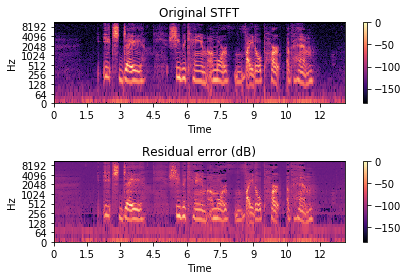

In [166]:
# Compare the results visually

plt.figure()
plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max, top_db=None),
                         y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Original STFT')
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(S_inv - S),
                                                 ref=S.max(), top_db=None),
                         vmax=0, y_axis='log', x_axis='time', cmap='magma')
plt.title('Residual error (dB)')
plt.colorbar()
plt.tight_layout()
plt.show()


In [171]:
y.shape

(144552,)

In [168]:
# Pick a short segment since pysptk.mcep function takes framed windowed waveform as an input

import pysptk

pos = 40000
frame_length = 1024

yw = y[pos:pos+frame_length] * pysptk.blackman(frame_length) # Blackman window

In [169]:
yw.shape

(1024,)

구린데....

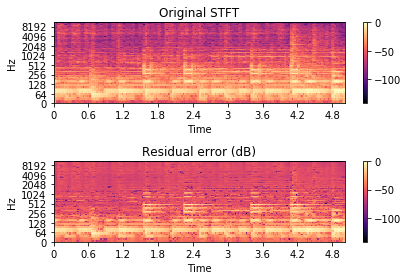

In [35]:
"""y, sr = librosa.load(librosa.util.example_audio_file(), duration=5, offset=10)
S = np.abs(librosa.stft(y))
mel_spec = librosa.feature.melspectrogram(S=S, sr=sr)
S_inv = librosa.feature.inverse.mel_to_stft(mel_spec, sr=sr)


plt.figure()
plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max, top_db=None),
                         y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Original STFT')
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(S_inv - S),
                                                 ref=S.max(), top_db=None),
                         vmax=0, y_axis='log', x_axis='time', cmap='magma')
plt.title('Residual error (dB)')
plt.colorbar()
plt.tight_layout()
plt.show()
"""

In [170]:
mceps = pysptk.mcep(S_inv)

RuntimeError: zero(s) are found in periodogram, use eps option to floor

### MCEPs 02 (pysptk mcep 뜯기)

In [172]:
### Mel-generalized cepstrum analysis ###

def mcep(np.ndarray[np.float64_t, ndim=1, mode="c"] windowed not None,

         order=25, alpha=0.35,

         miniter=2,

         maxiter=30,

         threshold=0.001,

         etype=0,

         eps=0.0,

         min_det=1.0e-6,

         itype=0):

    if not itype in range(0, 5):

        raise ValueError("unsupported itype: %d, must be in 0:4" % itype)



    if not etype in range(0, 3):

        raise ValueError("unsupported etype: %d, must be in 0:2" % etype)



    if etype == 0 and eps != 0.0:

        raise ValueError("eps cannot be specified for etype = 0")



    if etype == 1 and eps < 0.0:

        raise ValueError("eps: %f, must be >= 0" % eps)



    if etype == 2 and eps >= 0.0:

        raise ValueError("eps: %f, must be < 0" % eps)



    if min_det < 0.0:

        raise ValueError("min_det must be positive: min_det = %f" % min_det)



    cdef np.ndarray[np.float64_t, ndim = 1, mode = "c"] x

    cdef np.ndarray[np.float64_t, ndim = 1, mode = "c"] mc

    cdef int frame_length

    if itype == 0:

       frame_length = len(windowed)

    else:

       frame_length = (len(windowed) - 1) * 2  # fftlen



    cdef int ret

    mc = np.empty(order + 1, dtype=np.float64)

    x = np.zeros(frame_length, dtype=np.float64)

    x[:len(windowed)] = windowed

    ret = _mcep(&x[0], frame_length, &mc[0],

                order, alpha, miniter, maxiter, threshold, etype, eps,

                min_det, itype)

    assert ret == -1 or ret == 0 or ret == 3 or ret == 4

    if ret == 3:

        raise RuntimeError("failed to compute mcep; error occured in theq")

    elif ret == 4:

        raise RuntimeError(

            "zero(s) are found in periodogram, use eps option to floor")



    return mc

SyntaxError: invalid syntax (<ipython-input-172-cf2045222597>, line 3)

### MCEPs 03

https://github.com/tuanad121/Python-WORLD/blob/master/world/main.py

In [55]:
cd Python-WORLD/world

D:\투빅스\audio_to_mel\Python-WORLD\world


In [56]:
from world import main

In [ ]:
#WORLD보코더 encde_mcep 
def encode_mcep(self, spec: np.ndarray, n0: int = 12, fs: int = 16000, lowhz=0, highhz=8000):
    """
    Warp magnitude spectrum with Mel-scale
    Then, cepstrum analysis with order of n0
    Spec is magnitude spectrogram (N x D) array
    """
    
    lowmel = self.hz2mel(lowhz)
    highmel = self.hz2mel(highhz)
    """return the real cepstrum X is N x D array; N frames and D dimensions"""
    Xl = np.log(spec)
    D = spec.shape[1]
    melpoints = np.linspace(lowmel, highmel, D)
    bin = np.floor(((D - 1) * 2 + 1) * self.mel2hz(melpoints) / fs)
    Xml = np.array([np.interp(bin, np.arange(D), s)
                    for s in Xl])  #
    Xc = irfft(Xml)  # Xl is real, not complex
    return Xc[:, :n0]

In [173]:
import pyworld

In [174]:
wav = y.astype(np.float64)

In [175]:
f0, timeaxis = pyworld.harvest(wav, fs = sr, frame_period = 5.0, f0_floor = 20.0, f0_ceil = 3500.0)


In [176]:
sp = pyworld.cheaptrick(wav, f0, timeaxis, fs=sr)

In [177]:
sp.shape , S.shape

((1312, 513), (513, 565))

In [178]:
np.array_equal(sp,S)

False

cheaptrick
https://github.com/tuanad121/Python-WORLD/blob/83e8f5b5875e96b27d7a01b62175cc932cdadf3c/world/cheaptrick.py

cheaptrick 알고리즘으로 spectogram생성. STFT가 아니다.


In [185]:
coded_sp = pyworld.code_spectral_envelope(sp,sr,13)

In [180]:
coded_sp.shape 

(1312, 13)

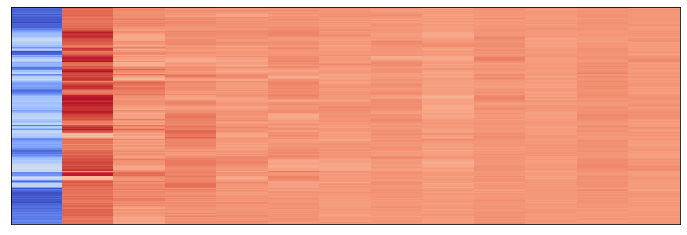

In [181]:
plt.figure(figsize=(12,4))
librosa.display.specshow(coded_sp)

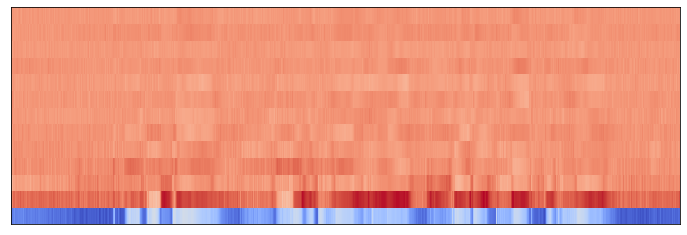

In [182]:
plt.figure(figsize=(12,4))
librosa.display.specshow(coded_sp.T)

MFCC와 비교

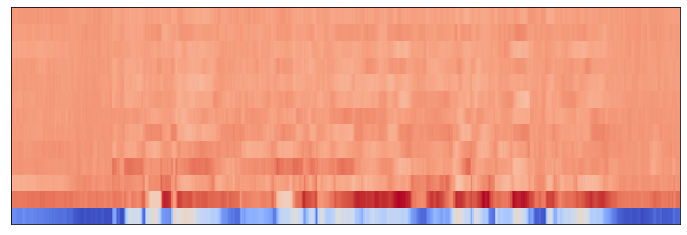

In [183]:
plt.figure(figsize=(12,4))
librosa.display.specshow(mfcc)

### F0
중심주파수

Mel -> Mel filter제거 -> (Linear Spectogram) -> Inverse STFT -> (f-domain) -> F0 추출

이건 inverse stft까지 해서 찾아야함....
inverse 두번

정보손실 너무 큼


In [ ]:
#build-in imports
from decimal import Decimal, ROUND_HALF_UP
import copy
import math

# 3rd-party imports
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import lfilter
from scipy import signal
from scipy.fftpack import fft
import numba

EPS = 2.220446049250313e-16


def harvest(x: np.ndarray, fs: int, f0_floor: int=71, f0_ceil: int=800, frame_period: int=5) -> dict:
    basic_frame_period: int = 1
    target_fs = 8000
    num_samples = int(1000 * len(x) / fs / basic_frame_period + 1)
    basic_temporal_positions = np.arange(0, num_samples) * basic_frame_period / 1000
    channels_in_octave = 40
    f0_floor_adjusted = f0_floor * 0.9
    f0_ceil_adjusted = f0_ceil * 1.1

    boundary_f0_list = np.arange(np.ceil(np.log2(f0_ceil_adjusted / f0_floor_adjusted) * channels_in_octave)) + 1
    boundary_f0_list = boundary_f0_list / channels_in_octave
    boundary_f0_list = 2.0 ** boundary_f0_list
    boundary_f0_list *= f0_floor_adjusted

    # down - sampling to target_fs Hz
    [y, actual_fs] = CalculateDownsampledSignal(x, fs, target_fs)
    fft_size = int(2 ** np.ceil(np.log2(len(y) + int(fs / f0_floor_adjusted * 4 + 0.5) + 1)))
    y_spectrum = np.fft.fft(y, fft_size)

    raw_f0_candidates = CalculateCandidates(len(basic_temporal_positions), boundary_f0_list, len(y),
                                            basic_temporal_positions, actual_fs, y_spectrum, f0_floor, f0_ceil)
    f0_candidates, number_of_candidates = DetectCandidates(raw_f0_candidates)
    f0_candidates = OverlapF0Candidates(f0_candidates, number_of_candidates)
    f0_candidates, f0_candidates_score = RefineCandidates(y, actual_fs,
                                                          basic_temporal_positions, f0_candidates, f0_floor, f0_ceil)
    f0_candidates, f0_candidates_score = RemoveUnreliableCandidates(f0_candidates, f0_candidates_score)

    connected_f0, vuv = FixF0Contour(f0_candidates, f0_candidates_score)
    smoothed_f0 = SmoothF0(connected_f0)
    num_samples = int(1000 * len(x) / fs / frame_period + 1)
    temporal_positions = np.arange(0, num_samples) * frame_period / 1000
    temporal_positions_sampe = np.minimum(len(smoothed_f0) - 1, round_matlab(temporal_positions * 1000))
    temporal_positions_sampe = np.array(temporal_positions_sampe, dtype=np.int)
    return {
        'temporal_positions': temporal_positions,
        'f0': smoothed_f0[temporal_positions_sampe],
        'vuv': vuv[temporal_positions_sampe]
    }


# Feature Extraction (from Audio)

## WORLD Vocoder 

F0, timeaxis, Sp (MCEPs), ap

https://r9y9.github.io/WORLD.jl/latest/index.html#WORLD.cheaptrick-Tuple{Union{DenseArray{Float64,1}


https://github.com/tuanad121/Python-WORLD/blob/master/world/main.py

##### MCEPs
audio -> Linear Spectogram -> spectral_envelop(MCEPs)

### MCEPs (using pysptk) 

In [38]:
"""import pysptk
from scipy.io import wavfile

def audio_to_MCEPs(y, pos, win_length=1024):
    
    #fs, x = wavfile.read(file_path)
    
    xw = y[pos:pos+win_length] * pysptk.blackman(win_length) # windowed audio
    mceps = pysptk.mcep(xw)
 
    return mceps"""
#???

In [39]:
audio_to_mceps = audio_to_MCEPs(y, 400, win_length=1024)

In [41]:
audio_to_mceps.shape

(26,)

### F0  (using pysptk)- SWIPE, RAPT

https://nbviewer.jupyter.org/github/r9y9/pysptk/blob/master/examples/pysptk%20introduction.ipynb

In [186]:
def audio_to_F0(y, sr = 22050, win_length=1024, hop_length=256, mode = "rapt"):
    if mode == "swipe":
        f0 = pysptk.swipe(y, fs=sr, hopsize=hop_length, otype="f0") # f0 using SWIPE
    else : 
        f0 = pysptk.swipe(y, fs=sr, hopsize=hop_length, otype="f0") 
        
    return f0

In [187]:
f0_rapt = audio_to_F0(y.astype(np.float64))
f0_swipe = audio_to_F0(y.astype(np.float64),mode = "swipe")

In [188]:
f0.shape, f0_swipe.shape

((1312,), (565,))

<function matplotlib.pyplot.show(*args, **kw)>

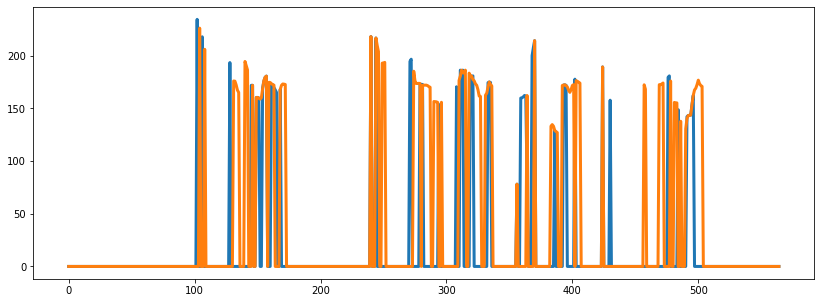

In [189]:
plt.figure(figsize=(14, 5))
plt.plot(f0_swipe, linewidth=3, label="F0 trajectory estimated by SWIPE'")
plt.plot(f0_rapt, linewidth=3,  label="F0 trajectory estimated by RAPT'")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

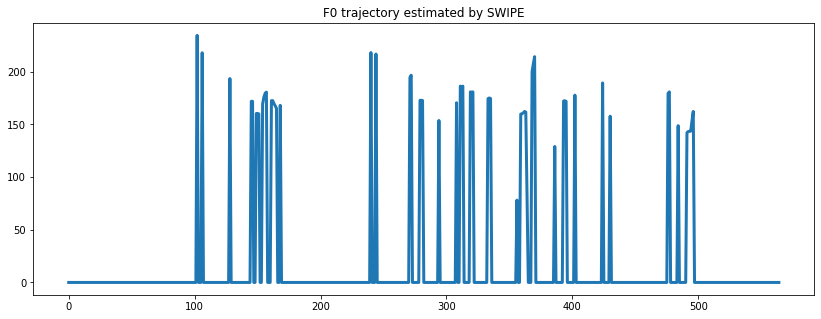

In [190]:
plt.figure(figsize=(14, 5))
plt.plot(f0_swipe, linewidth=3, label="F0 trajectory estimated by SWIPE'")
plt.title('F0 trajectory estimated by SWIPE')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

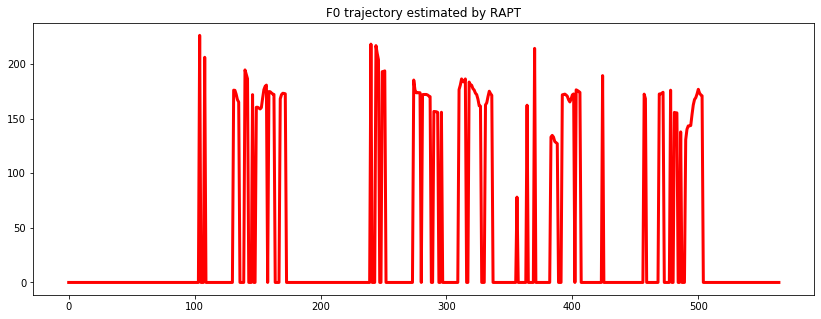

In [191]:
plt.figure(figsize=(14, 5))
plt.plot(f0_rapt, linewidth=3,  color='r',label="F0 trajectory estimated by RAPT")
plt.title('F0 trajectory estimated by RAPT')
plt.show

### F0  (using WORLD) - Harvest,Dio,StoneMask

https://github.com/tuanad121/Python-WORLD/blob/master/world/harvest.py

In [192]:
f0_h, timeaxis_h = pyworld.harvest(y.astype(np.float64), sr, frame_period = 5.0, f0_floor = 20.0, f0_ceil = 3500.0)
f0_d, timeaxis_d = pyworld.dio(y.astype(np.float64), sr, frame_period = 5.0, f0_floor = 20.0, f0_ceil = 3500.0)
#f0_s, timeaxis_s = pyworld.stonemask(y.astype(np.float64), sr, frame_period = 5.0, f0_floor = 20.0, f0_ceil = 3500.0)

<function matplotlib.pyplot.show(*args, **kw)>

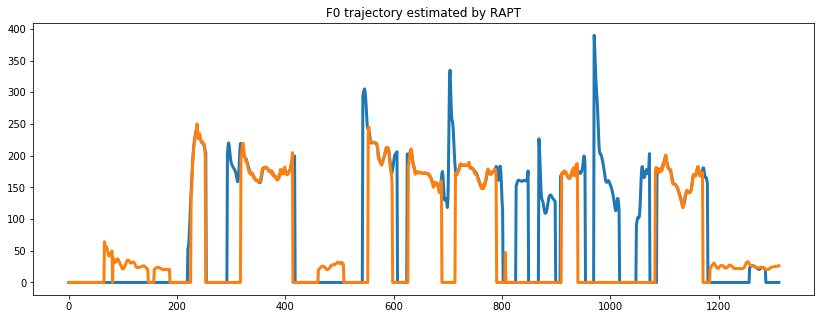

In [193]:
plt.figure(figsize=(14, 5))
plt.plot(f0_h, linewidth=3, label="F0 trajectory estimated by harvest")
plt.plot(f0_d, linewidth=3, label="F0 trajectory estimated by dio")
plt.title('F0 trajectory estimated by RAPT')
plt.show

난리났네

### Seperation of Harmonic and Percussive Signals

Text(0.5, 1.0, 'Harmonic + Percussive')

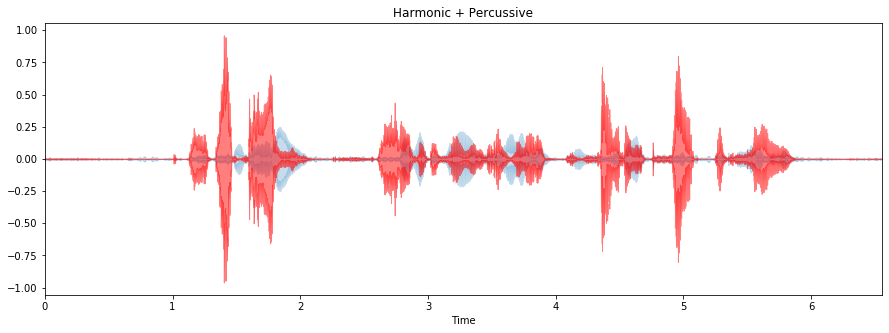

In [194]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y_harmonic, sr=sr, alpha=0.25)
librosa.display.waveplot(y_percussive, sr=sr, color='r', alpha=0.5)
plt.title('Harmonic + Percussive')

In [195]:
y.shape

(144552,)

(144552,)


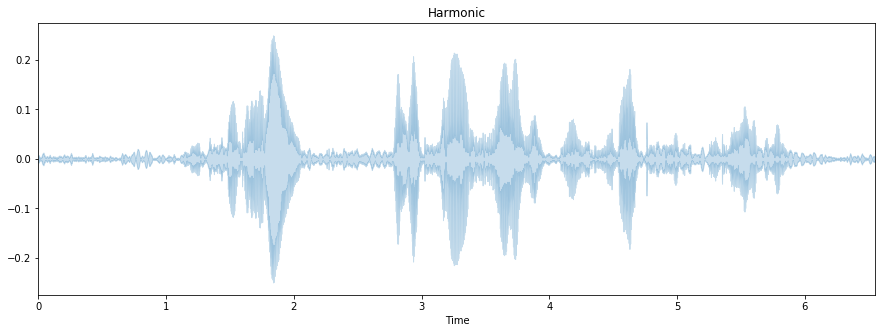

In [196]:
print(y_harmonic.shape)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y_harmonic, sr=sr, alpha=0.25)
plt.title('Harmonic')
ipd.Audio(y_harmonic, rate=sr)

(144552,)


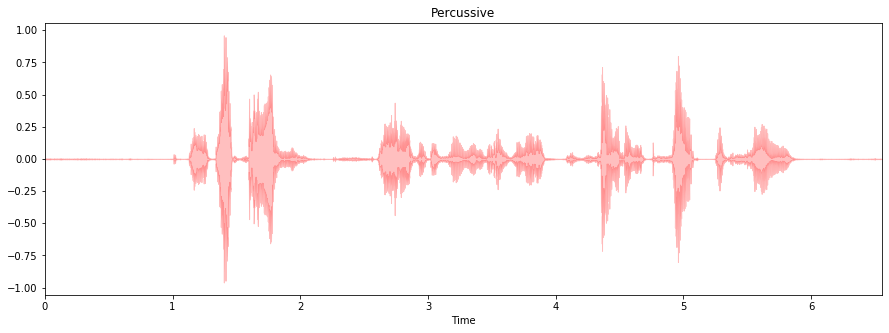

In [197]:
print(y_percussive.shape)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y_percussive, color='r',sr=sr, alpha=0.25)
plt.title('Percussive')
ipd.Audio(y_percussive, rate=sr)

### Spectral Centroid

sound의 brightness측정에 유용 

고주파

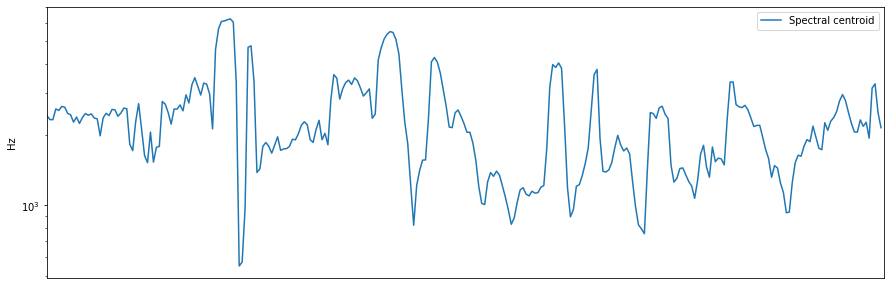

In [198]:
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
plt.figure(figsize=(15,5))
plt.subplot(1, 1, 1)
plt.semilogy(cent.T, label='Spectral centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, cent.shape[-1]])
plt.legend()

In [200]:
cent.shape

(1, 283)

### Spectral Contrast

Text(0.5, 1.0, 'Spectral contrast')

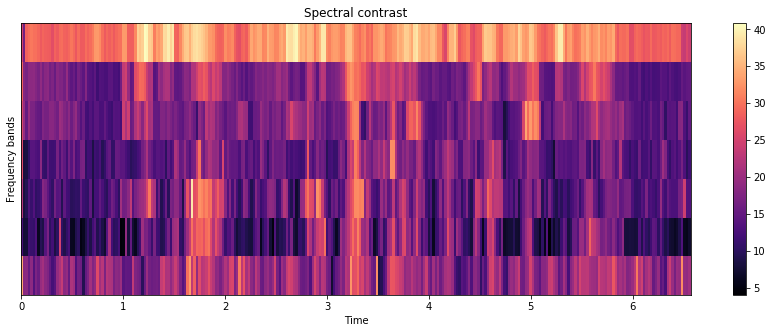

In [202]:
contrast=librosa.feature.spectral_contrast(y=y,sr=sr)
plt.figure(figsize=(15,5))
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.ylabel('Frequency bands')
plt.title('Spectral contrast')

### Spectral Rolloff

낮은 주파수영역의 에너지 집중정도

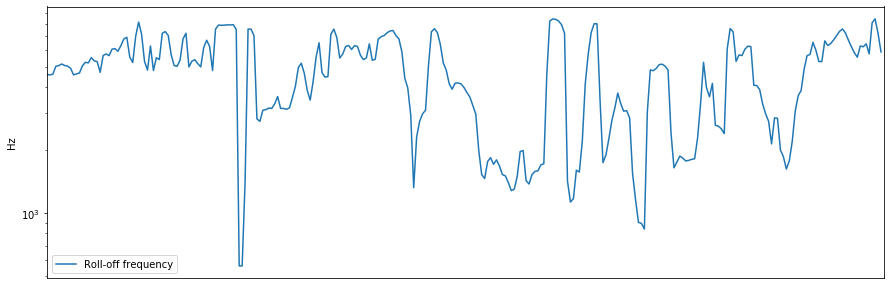

In [203]:
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
plt.figure(figsize=(15,5))
plt.semilogy(rolloff.T, label='Roll-off frequency')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, rolloff.shape[-1]])
plt.legend()

### Zero Crossing Rate

sound 내의 고주파 

유/무성음의 판별에 자주 사용

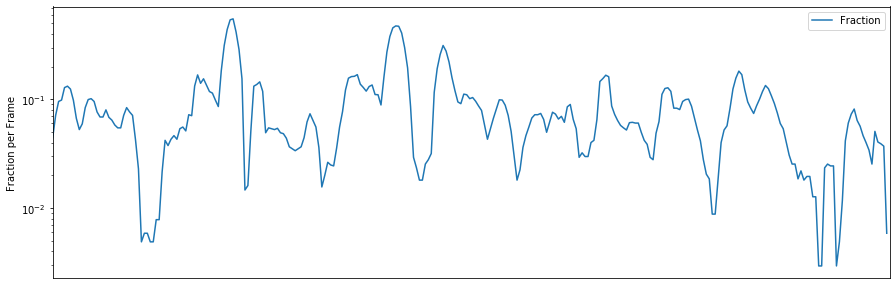

In [204]:
zrate=librosa.feature.zero_crossing_rate(y)
plt.figure(figsize=(15,5))
plt.semilogy(zrate.T, label='Fraction')
plt.ylabel('Fraction per Frame')
plt.xticks([])
plt.xlim([0, rolloff.shape[-1]])
plt.legend()

살려줘`